In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import pdb
import copy
from scipy import sparse
import anndata
import cerberus
import subprocess
from pandarallel import pandarallel

p = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [1]:
fig_dir = '/Users/fairliereese/mortazavi_lab/documents/rnawg/fig4'

h5 = '../cerberus_annot.h5'
filt_ab = '../cerberus_filtered_abundance.tsv'
feat = 'tss'
obs_source = 'lapa'
ref_sources = ['v40', 'v29']
support_sources = ['encode_cage',
                   'fantom_cage',
                   'encode_rampage']                   
support_label = 'CAGE, RAMPAGE'

In [34]:
sg = swan.read(swan_file)

Read in graph from ../swan/swan.p


In [35]:
ca = cerberus.read(c_annot)

In [61]:
def get_centroid_df(ca, source):
    
    keep_cols = ['gname', 'gid', 'tss_ratio', 'tes_ratio', 'spl_ratio', 'n_iso', 'source']
    
    # compute centroid for each  sample / gene pairing for the different sources
    df = ca.triplets.loc[(ca.triplets.source == source)].copy(deep=True)
    df = cerberus.compute_simplex_coords(df, 'splicing_ratio')
    df = df[keep_cols]
    df = df.groupby(['gname', 'gid', 'source']).mean().reset_index()
    df = assign_sector(df)   
    
    # only protein coding genes
    gene_df, _, _ = get_gtf_info(how='gene', ver='v40_cerberus', add_stable_gid=True)
    gene_df = gene_df[['gid_stable', 'biotype']]
    df = df.merge(gene_df, how='left', left_on='gid', right_on='gid_stable')
    df = df.loc[df.biotype=='protein_coding']    
    
    return df

In [62]:
df_det = get_centroid_df(ca, 'sample_det')
df_major = get_centroid_df(ca, 'sample_major')
print(len(df_det.index))
df = df_det.merge(df_major, how='inner', on=['gid', 'gname'], suffixes=('_det', '_major'))
print(len(df_det.index))


17523
17523


In [63]:
# compute distances
pandarallel.initialize(nb_workers=8, verbose=1)
df['dist'] = df.parallel_apply(simplex_dist_x,
                               args=('_major', '_det'),
                               axis=1)
df.dist = df.dist.fillna(0)

## Sankey plot + statistics

  sector_det sector_major    gid
0      mixed        mixed  12040
1      mixed       simple    387
2      mixed     splicing     88
3      mixed          tes    269
4      mixed          tss     33
{'tss': '#56B4E9', 'splicing': '#CC79A7', 'tes': '#E69F00', 'simple': '#000000', 'mixed': '#b7b7b7'}


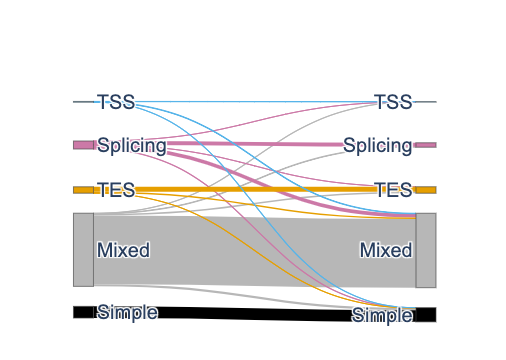

In [64]:
ofile = 'figures/sample_det_sample_major_centroid_sankey.pdf'
counts = df[['gid', 'sector_det', 'sector_major']].groupby(['sector_det', 'sector_major']).count().reset_index().copy(deep=True)
print(counts.head())
fig = plot_sankey(counts,
                  source='sector_det',
                  sink='sector_major',
                  counts='gid',
                  color='sector',
                  title='')
h = 700
w = 1.8792590838529746*h
pio.write_image(fig, ofile, width=w, height=h)

In [65]:
counts

,sector_det,sector_major,gid,source,sink
0,mixed,mixed,12040,3,8
1,mixed,simple,387,3,9
2,mixed,splicing,88,3,6
3,mixed,tes,269,3,7
4,mixed,tss,33,3,5
5,simple,simple,2045,4,9
6,splicing,mixed,666,1,8
7,splicing,simple,45,1,9
8,splicing,splicing,689,1,6
9,splicing,tes,5,1,7


In [41]:
# what overall % are the same?
def compute_sankey_summary(df, source, sink):
    df['same'] = df[source] == df[sink]
    temp = df[['gid', 'same']].groupby('same').sum().reset_index()
    n = temp.loc[temp.same == True, 'gid'].values[0]/temp.gid.sum()
    print('{:.2f}% of protein coding genes are in the same sector b/w obs and obs major'.format(n*100))
    
    for s in [source, sink]:
        print()
        total_det = df[[s, 'gid']].groupby(s).sum().reset_index().copy(deep=True)
        total_det.rename({'gid': 'total'}, axis=1, inplace=True)
        print(total_det)

In [42]:
compute_sankey_summary(counts, 'sector_det', 'sector_major')

89.49% of protein coding genes are in the same sector b/w obs and obs major

  sector_det  total
0      mixed  12817
1     simple   2045
2   splicing   1406
3        tes   1123
4        tss    132

  sector_major  total
0        mixed  13046
1       simple   2485
2     splicing    777
3          tes   1135
4          tss     80


## Gene w/ high dist b/w sample major and det centroids

In [43]:
# add centroids to triplets
df_det['source'] = 'sample_det_centroid'
ca.triplets = pd.concat([ca.triplets, df_det], axis=0)

df_major['source'] = 'sample_major_centroid'
ca.triplets = pd.concat([ca.triplets, df_major], axis=0)

In [44]:
# df = df.loc[df.sector_det == 'mixed'].copy(deep=True)
# df = df.loc[df.sector_major.isin(['tss', 'tes', 'splicing'])]

# add gene info
gene_df, _, _ = get_gtf_info(how='gene', ver='v40_cerberus')
gene_df['gid_stable'] = cerberus.get_stable_gid(gene_df, col='gid')
gene_df = gene_df[['gid_stable', 'tf']]
df = df.merge(gene_df, how='left', left_on='gid', right_on='gid_stable')

In [46]:
df.loc[df.tf==True].sort_values(by='dist', ascending=False)[['gname', 'sector_det', 'sector_major', 'dist']].head(20)
df.sort_values(by='dist', ascending=False)[['gname', 'sector_det', 'sector_major', 'dist']].head(20)
df.loc[(df.sector_det=='mixed')&(df.sector_major.isin(['tss', 'splicing', 'tes']))].sort_values(by='dist', ascending=False)[['gname', 'sector_det', 'sector_major', 'dist']].head(20)

,gname,sector_det,sector_major,dist
10241,OAZ1,mixed,tes,0.256559
11607,PRELID1,mixed,tes,0.232461
5945,GHITM,mixed,tes,0.225891
16406,VDAC2,mixed,tes,0.222304
10916,PGD,mixed,tes,0.220775
16239,UNC13C,mixed,tes,0.220634
14616,SUMO1,mixed,tes,0.216542
6532,HADHB,mixed,tes,0.213387
3160,COL3A1,mixed,tes,0.211647
10307,OPALIN,mixed,tes,0.210976


In [16]:
def plot_simplex_here(ca, gene):
    # det
    c_dict, order = get_biosample_colors()
    c_dict[np.nan] = 'k'
    mmap = {'v40': '*', 'v29': 'x', 'obs_det': '^', 'cerberus': '2', 'sample_det_centroid': 'x'} 
    subset = {'source': ['v40', 'obs_det', 'sample_det', 'sample_det_centroid']}
    fname='figures/simplex_{}_det.pdf'.format(gene.lower())
    df = ca.plot_simplex(top='splicing_ratio', 
                gene=gene,
                hue='sample',
                cmap=c_dict,
                density=True,
                density_scale=50,
                density_cmap='Purples',
                size='gene_tpm', 
                log_size=True,
                sectors=True,
                marker_style='source',
                mmap=mmap,
                legend=False,
                jitter=True,
                subset=subset,
                size_scale=0.5,
                fname=fname)  
    print(df.source.unique())
    
    mmap = {'v40': '*', 'v29': 'x', 'obs_major': '^', 'cerberus': '2', 'sample_major_centroid': 'x'} 
    subset = {'source': ['v40', 'obs_major', 'sample_major', 'sample_major_centroid']}
    fname='figures/simplex_{}_major.pdf'.format(gene.lower())
    df = ca.plot_simplex(top='splicing_ratio', 
                gene=gene,
                hue='sample',
                cmap=c_dict,
                density=True,
                density_scale=50,
                density_cmap='Purples',
                size='gene_tpm', 
                log_size=True,
                sectors=True,
                marker_style='source',
                mmap=mmap,
                legend=False,
                jitter=True,
                subset=subset,
                size_scale=0.5,
                fname=fname)
    print(df.source.unique())
    

['v40' 'obs_det' 'sample_det' 'sample_det_centroid']
['v40' 'obs_major' 'sample_major' 'sample_major_centroid']


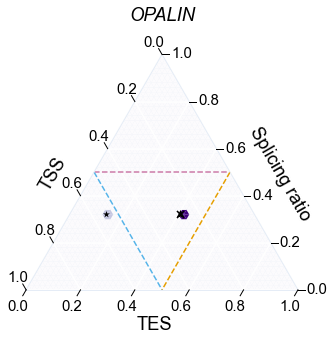

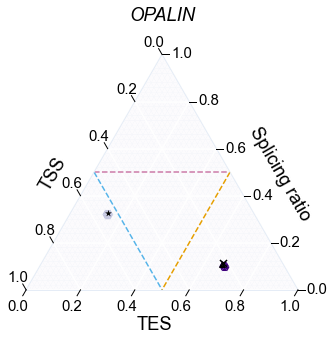

In [49]:
plot_simplex_here(ca, 'OPALIN')

In [57]:
ca.triplets.loc[(ca.triplets.gname=='OPALIN')&(ca.triplets.source=='sample_det')].sort_values(by='gene_tpm', ascending=False)

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,gname,sample,gene_tpm,sector,gid_stable,biotype
25683,sample_det,ENSG00000197430,2.0,3.0,6.0,21.0,2.4,0.27027,0.405405,0.324324,OPALIN,brain,175.861877,NaN,NaN,NaN


In [58]:
ca.triplets.loc[(ca.triplets.gname=='OPALIN')&(ca.triplets.source=='sample_major')].sort_values(by='gene_tpm', ascending=False)

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,gname,sample,gene_tpm,sector,gid_stable,biotype
25683,sample_major,ENSG00000197430,1.0,3.0,1.0,3.0,0.5,0.222222,0.666667,0.111111,OPALIN,brain,175.861877,NaN,NaN,NaN


Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1817: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1816: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
small text size: 20.3
big text size: 17.571194762684122


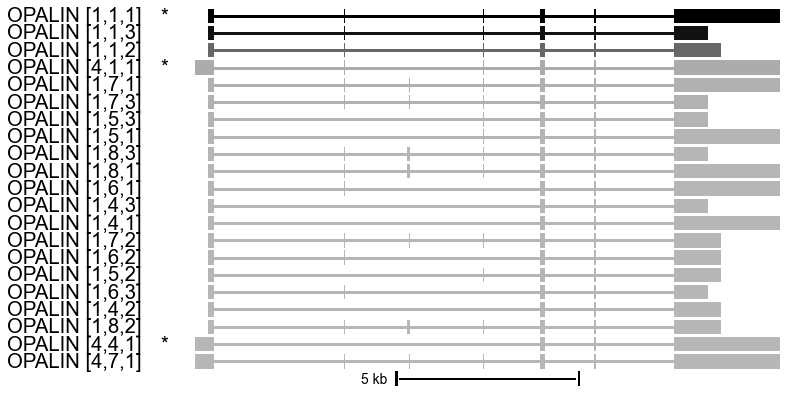

In [59]:
gene = 'OPALIN'
obs_col = 'sample'
obs_condition = 'brain'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                                         obs_col, obs_condition,
                                         filt_ab, major_set,
                                         h_space=0.24,
                                         h=0.2, ref_source='v40',
                                         major=False)

small text size: 20.3
big text size: 17.571194762684122


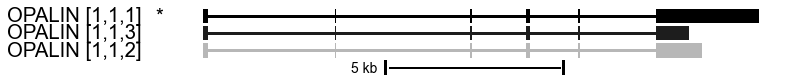

In [60]:
gene = 'OPALIN'
obs_col = 'sample'
obs_condition = 'brain'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                                         obs_col, obs_condition,
                                         filt_ab, major_set,
                                         h_space=0.24,
                                         h=0.2, ref_source='v40',
                                         major=True)

['v40' 'obs_det' 'sample_det' 'sample_det_centroid']
['v40' 'obs_major' 'sample_major' 'sample_major_centroid']


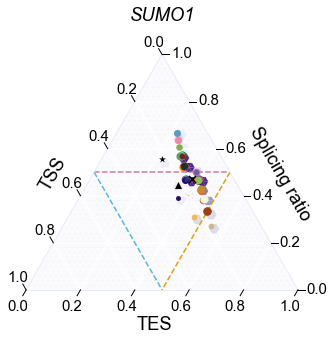

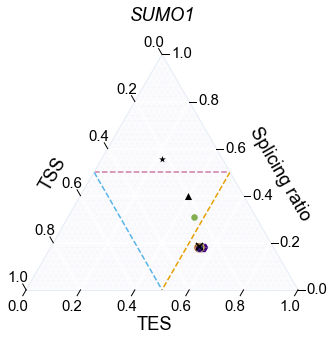

In [48]:
plot_simplex_here(ca, 'SUMO1')

In [53]:
ca.triplets.loc[(ca.triplets.gname=='SUMO1')&(ca.triplets.source=='sample_det')&(ca.triplets.spl_ratio <0.5)].sort_values(by='gene_tpm', ascending=False)

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,gname,sample,gene_tpm,sector,gid_stable,biotype
241185,sample_det,ENSG00000116030,1.0,3.0,7.0,12.0,3.500000,0.133333,0.400000,0.466667,SUMO1,h9_neural_crest,444.393127,NaN,NaN,NaN
227460,sample_det,ENSG00000116030,1.0,3.0,6.0,13.0,3.000000,0.142857,0.428571,0.428571,SUMO1,h1,405.137146,NaN,NaN,NaN
500956,sample_det,ENSG00000116030,1.0,3.0,4.0,8.0,2.000000,0.166667,0.500000,0.333333,SUMO1,h9,362.138062,NaN,NaN,NaN
582930,sample_det,ENSG00000116030,1.0,3.0,6.0,10.0,3.000000,0.142857,0.428571,0.428571,SUMO1,h9_panc_beta,357.614105,NaN,NaN,NaN
572989,sample_det,ENSG00000116030,1.0,3.0,5.0,10.0,2.500000,0.153846,0.461538,0.384615,SUMO1,h9_osteocyte,341.777985,NaN,NaN,NaN
188086,sample_det,ENSG00000116030,1.0,3.0,4.0,9.0,2.000000,0.166667,0.500000,0.333333,SUMO1,h9_panc_progen,335.352356,NaN,NaN,NaN
407066,sample_det,ENSG00000116030,1.0,3.0,7.0,14.0,3.500000,0.133333,0.400000,0.466667,SUMO1,pgp1,323.255737,NaN,NaN,NaN
305444,sample_det,ENSG00000116030,1.0,3.0,7.0,13.0,3.500000,0.133333,0.400000,0.466667,SUMO1,wtc11,312.598114,NaN,NaN,NaN
268285,sample_det,ENSG00000116030,1.0,3.0,7.0,12.0,3.500000,0.133333,0.400000,0.466667,SUMO1,gm12878,302.175873,NaN,NaN,NaN
488214,sample_det,ENSG00000116030,1.0,3.0,7.0,16.0,3.500000,0.133333,0.400000,0.466667,SUMO1,hffc6,284.056519,NaN,NaN,NaN


In [51]:
ca.triplets.loc[(ca.triplets.gname=='SUMO1')&(ca.triplets.source=='sample_major')]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,gname,sample,gene_tpm,sector,gid_stable,biotype
3271,sample_major,ENSG00000116030,1.0,2.0,1.0,2.0,0.666667,0.272727,0.545455,0.181818,SUMO1,caco2,345.260010,NaN,NaN,NaN
16899,sample_major,ENSG00000116030,1.0,2.0,1.0,2.0,0.666667,0.272727,0.545455,0.181818,SUMO1,brain,229.993195,NaN,NaN,NaN
33999,sample_major,ENSG00000116030,1.0,2.0,1.0,2.0,0.666667,0.272727,0.545455,0.181818,SUMO1,mcf10a,144.672226,NaN,NaN,NaN
45921,sample_major,ENSG00000116030,1.0,2.0,1.0,2.0,0.666667,0.272727,0.545455,0.181818,SUMO1,a673,360.575012,NaN,NaN,NaN
59412,sample_major,ENSG00000116030,1.0,2.0,1.0,2.0,0.666667,0.272727,0.545455,0.181818,SUMO1,lung,97.386902,NaN,NaN,NaN
76584,sample_major,ENSG00000116030,1.0,2.0,1.0,2.0,0.666667,0.272727,0.545455,0.181818,SUMO1,hl60_m0,108.740326,NaN,NaN,NaN
88057,sample_major,ENSG00000116030,1.0,2.0,1.0,2.0,0.666667,0.272727,0.545455,0.181818,SUMO1,colon,111.805016,NaN,NaN,NaN
103501,sample_major,ENSG00000116030,1.0,2.0,1.0,2.0,0.666667,0.272727,0.545455,0.181818,SUMO1,hmec,230.723480,NaN,NaN,NaN
115651,sample_major,ENSG00000116030,1.0,2.0,1.0,2.0,0.666667,0.272727,0.545455,0.181818,SUMO1,k562,88.109688,NaN,NaN,NaN
128647,sample_major,ENSG00000116030,1.0,2.0,1.0,2.0,0.666667,0.272727,0.545455,0.181818,SUMO1,imr90,136.918365,NaN,NaN,NaN


Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
small text size: 20.3
big text size: 17.571194762684122


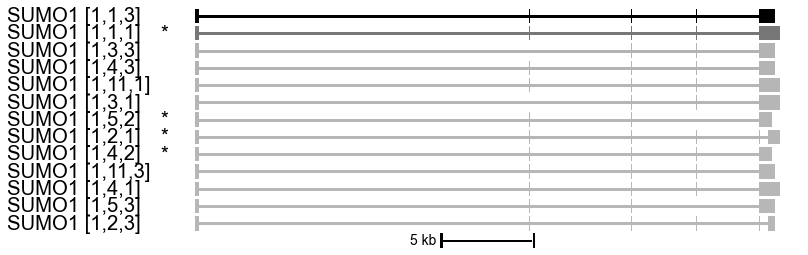

In [55]:
gene = 'SUMO1'
obs_col = 'sample'
obs_condition = 'h1'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                                         obs_col, obs_condition,
                                         filt_ab, major_set,
                                         h_space=0.24,
                                         h=0.2, ref_source='v40',
                                         major=False)

small text size: 20.3
big text size: 17.571194762684122


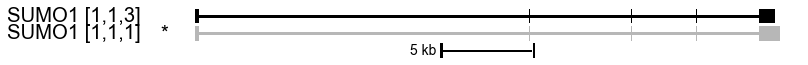

In [56]:
gene = 'SUMO1'
obs_col = 'sample'
obs_condition = 'h1'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                                         obs_col, obs_condition,
                                         filt_ab, major_set,
                                         h_space=0.24,
                                         h=0.2, ref_source='v40',
                                         major=True)

['v40' 'obs_det' 'sample_det' 'sample_det_centroid']
['v40' 'obs_major' 'sample_major' 'sample_major_centroid']


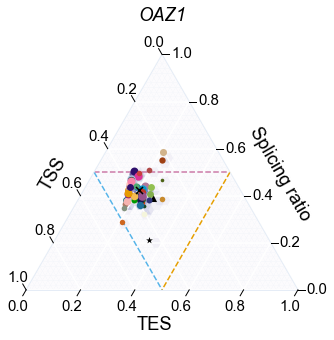

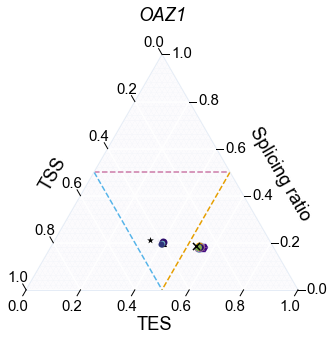

In [47]:
plot_simplex_here(ca, 'OAZ1')

['v40' 'obs_det' 'sample_det' 'sample_det_centroid']
['v40' 'obs_major' 'sample_major' 'sample_major_centroid']


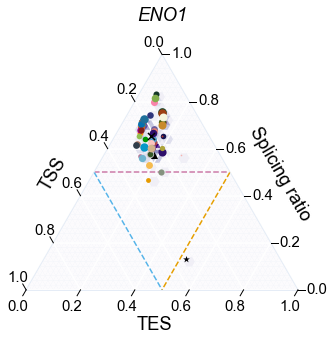

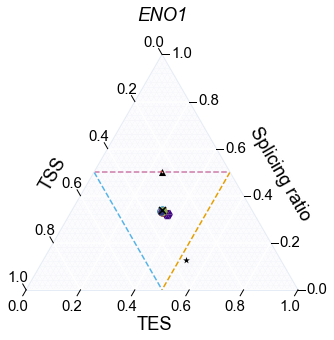

In [17]:
plot_simplex_here(ca, 'ENO1')

In [23]:
ca.triplets.loc[(ca.triplets.gname=='ENO1')&(ca.triplets.source=='sample_det')]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,gname,sample,gene_tpm,sector,gid_stable,biotype
925,sample_det,ENSG00000074800,3.0,1.0,16.0,17.0,8.000000,0.250000,0.083333,0.666667,ENO1,caco2,1578.975220,NaN,NaN,NaN
14256,sample_det,ENSG00000074800,4.0,2.0,24.0,25.0,8.000000,0.285714,0.142857,0.571429,ENO1,brain,890.910339,NaN,NaN,NaN
31857,sample_det,ENSG00000074800,3.0,1.0,20.0,21.0,10.000000,0.214286,0.071429,0.714286,ENO1,mcf10a,4367.829102,NaN,NaN,NaN
43640,sample_det,ENSG00000074800,3.0,2.0,21.0,22.0,8.400000,0.223881,0.149254,0.626866,ENO1,a673,3755.087891,NaN,NaN,NaN
56635,sample_det,ENSG00000074800,3.0,2.0,27.0,30.0,10.800000,0.189873,0.126582,0.683544,ENO1,lung,2785.571045,NaN,NaN,NaN
74665,sample_det,ENSG00000074800,3.0,2.0,17.0,18.0,6.800000,0.254237,0.169492,0.576271,ENO1,hl60_m0,3797.031738,NaN,NaN,NaN
85464,sample_det,ENSG00000074800,3.0,2.0,17.0,17.0,6.800000,0.254237,0.169492,0.576271,ENO1,colon,1332.100586,NaN,NaN,NaN
101278,sample_det,ENSG00000074800,3.0,1.0,19.0,20.0,9.500000,0.222222,0.074074,0.703704,ENO1,hmec,2620.105957,NaN,NaN,NaN
113538,sample_det,ENSG00000074800,3.0,3.0,25.0,26.0,8.333333,0.209302,0.209302,0.581395,ENO1,k562,7013.040039,NaN,NaN,NaN
126490,sample_det,ENSG00000074800,2.0,2.0,20.0,20.0,10.000000,0.142857,0.142857,0.714286,ENO1,imr90,1935.801758,NaN,NaN,NaN


Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1817: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1816: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
small text size: 20.3
big text size: 17.571194762684122


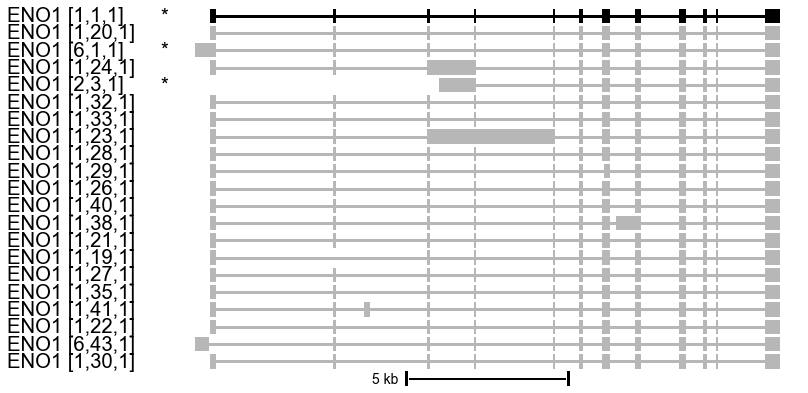

In [26]:
gene = 'ENO1'
obs_col = 'sample'
obs_condition = 'mcf10a'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                                         obs_col, obs_condition,
                                         filt_ab, major_set,
                                         h_space=0.24,
                                         h=0.2, ref_source='v40',
                                         major=False)

small text size: 20.3
big text size: 17.571194762684122


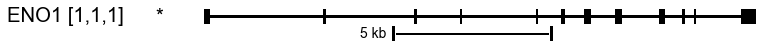

In [27]:
gene = 'ENO1'
obs_col = 'sample'
obs_condition = 'mcf10a'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                                         obs_col, obs_condition,
                                         filt_ab, major_set,
                                         h_space=0.24,
                                         h=0.2, ref_source='v40',
                                         major=True)

['v40' 'obs_det' 'sample_det' 'sample_det_centroid']
['v40' 'obs_major' 'sample_major' 'sample_major_centroid']


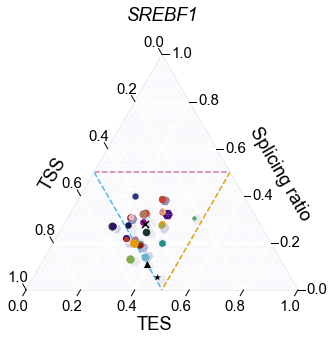

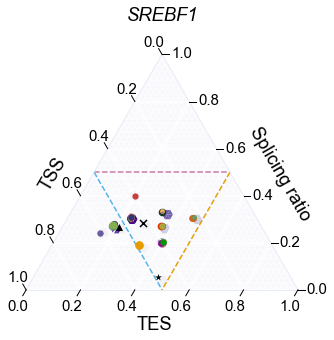

In [18]:
plot_simplex_here(ca, 'SREBF1')

['v40' 'obs_det' 'sample_det' 'sample_det_centroid']
['v40' 'obs_major' 'sample_major' 'sample_major_centroid']


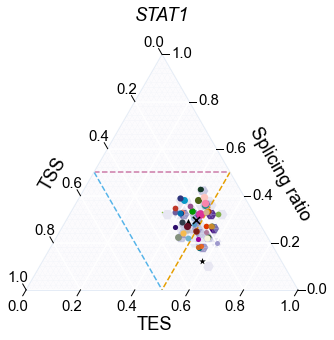

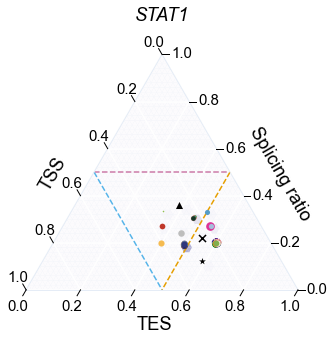

In [19]:
plot_simplex_here(ca, 'STAT1')

['v40' 'obs_det' 'sample_det' 'sample_det_centroid']
['v40' 'obs_major' 'sample_major' 'sample_major_centroid']


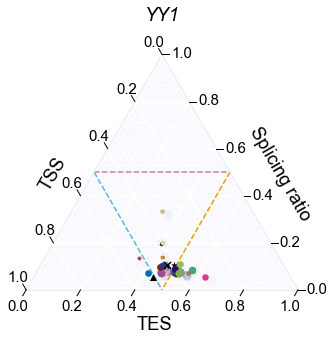

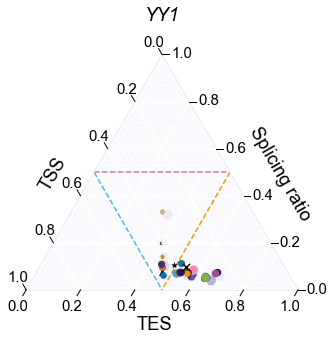

In [20]:
plot_simplex_here(ca, 'YY1')

In [28]:
df.loc[df.tf==True].sort_values(by='dist', ascending=False)[['gname', 'sector_det', 'sector_major', 'dist']].head(20)

,gname,sector_det,sector_major,dist
243,POU1F1,mixed,tes,0.103966
306,SREBF2,mixed,tes,0.090699
312,STAT1,mixed,tes,0.062247
379,YY1,mixed,tes,0.047968
36,ATMIN,mixed,tes,0.046286
384,ZNF3,mixed,splicing,0.042160
213,NR2C1,mixed,splicing,0.041247
324,TGIF1,mixed,tss,0.037957
71,CREBZF,mixed,tes,0.032250
386,ZNF584,mixed,splicing,0.024625


['v40' 'obs_det' 'sample_det' 'sample_det_centroid']
['v40' 'obs_major' 'sample_major' 'sample_major_centroid']


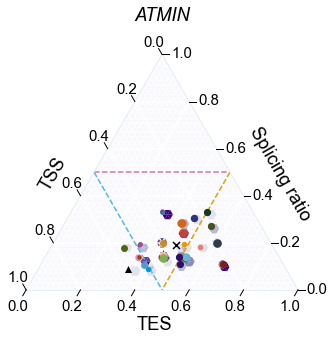

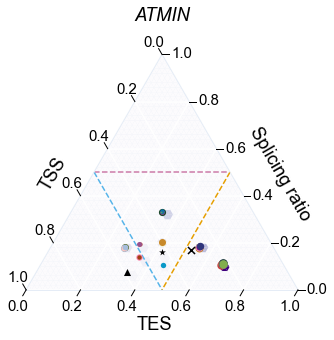

In [29]:
plot_simplex_here(ca, 'ATMIN')

In [31]:
df.sort_values(by='dist', ascending=False).head(20)

,gname,gid,source_det,tss_ratio_det,tes_ratio_det,spl_ratio_det,n_iso_det,sector_det,gid_stable_det,biotype_det,...,tss_ratio_major,tes_ratio_major,spl_ratio_major,n_iso_major,sector_major,gid_stable_major,biotype_major,dist,gid_stable,tf
216,OAZ1,ENSG00000104904,sample_det,0.378043,0.200776,0.421181,23.900000,mixed,ENSG00000104904,protein_coding,...,0.285455,0.530909,0.183636,2.100000,tes,ENSG00000104904,protein_coding,0.256559,ENSG00000104904,False
250,PRELID1,ENSG00000169230,sample_det,0.172443,0.335894,0.491664,7.360000,mixed,ENSG00000169230,protein_coding,...,0.273939,0.541212,0.184848,1.980000,tes,ENSG00000169230,protein_coding,0.232461,ENSG00000169230,False
134,GHITM,ENSG00000165678,sample_det,0.142871,0.376019,0.481110,10.440000,mixed,ENSG00000165678,protein_coding,...,0.275152,0.536970,0.187879,1.960000,tes,ENSG00000165678,protein_coding,0.225891,ENSG00000165678,False
370,VDAC2,ENSG00000165637,sample_det,0.217557,0.293825,0.488618,13.980000,mixed,ENSG00000165637,protein_coding,...,0.277949,0.522564,0.199487,1.920000,tes,ENSG00000165637,protein_coding,0.222304,ENSG00000165637,False
235,PGD,ENSG00000142657,sample_det,0.165779,0.363929,0.470291,8.680000,mixed,ENSG00000142657,protein_coding,...,0.272727,0.545455,0.181818,2.000000,tes,ENSG00000142657,protein_coding,0.220775,ENSG00000142657,False
363,UNC13C,ENSG00000137766,sample_det,0.176471,0.352941,0.470588,8.000000,mixed,ENSG00000137766,protein_coding,...,0.272727,0.545455,0.181818,2.000000,tes,ENSG00000137766,protein_coding,0.220634,ENSG00000137766,False
320,SUMO1,ENSG00000116030,sample_det,0.156350,0.374461,0.469189,8.980000,mixed,ENSG00000116030,protein_coding,...,0.271049,0.542098,0.186853,2.040000,tes,ENSG00000116030,protein_coding,0.216542,ENSG00000116030,False
149,HADHB,ENSG00000138029,sample_det,0.241661,0.299367,0.458972,12.440000,mixed,ENSG00000138029,protein_coding,...,0.271422,0.536177,0.192401,2.040000,tes,ENSG00000138029,protein_coding,0.213387,ENSG00000138029,False
68,COL3A1,ENSG00000168542,sample_det,0.182324,0.336280,0.481396,13.041667,mixed,ENSG00000168542,protein_coding,...,0.280303,0.518939,0.200758,1.875000,tes,ENSG00000168542,protein_coding,0.211647,ENSG00000168542,False
219,OPALIN,ENSG00000197430,sample_det,0.270270,0.405405,0.324324,21.000000,mixed,ENSG00000197430,protein_coding,...,0.222222,0.666667,0.111111,3.000000,tes,ENSG00000197430,protein_coding,0.210976,ENSG00000197430,False
